In [2]:
## The following code ensures that the project root directory is added to Python’s module search path. 
## This allows us to import reusable logic and configuration files from the src/ folder.
## By separating analysis (notebooks) from reusable logic (src modules), we maintain a clean, modular project structure similar to production-grade analytics workflows.
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

from src.config import VARIANTS, DAILY_INSTALLS
print(VARIANTS.keys(), DAILY_INSTALLS)

dict_keys(['A', 'B']) 20000


# Task 1 – A/B Test Simulation Analysis

This analysis evaluates the long-term revenue performance of two game variants (A and B).

The goal is to simulate:

Daily installs

User retention

Daily Active Users (DAU)

Monetization from in-app purchases and ads

Using an exponential retention model, we estimate user survival curves and simulate a 30-day cohort model to compare cumulative revenue performance.

In the first section of this notebook, we address parts (a), (b), and (c) of Task 1:

In [3]:
## Since the notebook is located inside the notebooks/ folder, we explicitly add the project root directory to Python’s module search path.
## This allows us to import reusable modules from the src/ folder and maintain a clean separation between analysis (notebooks) and business logic (src modules).
 

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added:", PROJECT_ROOT)

Project root added: E:\Projects\vertigo-case


Retention Curve Estimation

Using the provided D1, D3, D7, and D14 retention data, we fit an exponential decay model of the form:

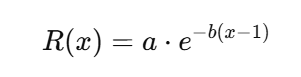

This allows us to estimate continuous daily retention values beyond the observed data points and simulate user survival behavior over longer horizons.

The fitted parameters represent:

a → initial retention level

b → retention decay 

These curves form the foundation of the DAU and revenue simulations.

In [4]:
from src.retention import fit_retention_curve
from src.config import VARIANTS

import matplotlib.pyplot as plt

# Variant A
days_A, retention_A, params_A = fit_retention_curve(
    VARIANTS["A"]["retention_points"]
)

# Variant B
days_B, retention_B, params_B = fit_retention_curve(
    VARIANTS["B"]["retention_points"]
)

print("Variant A parameters:", params_A)
print("Variant B parameters:", params_B)

Variant A parameters: (np.float64(0.5029630570419545), np.float64(0.21454032729022018))
Variant B parameters: (np.float64(0.4406555843400975), np.float64(0.15889906471878484))


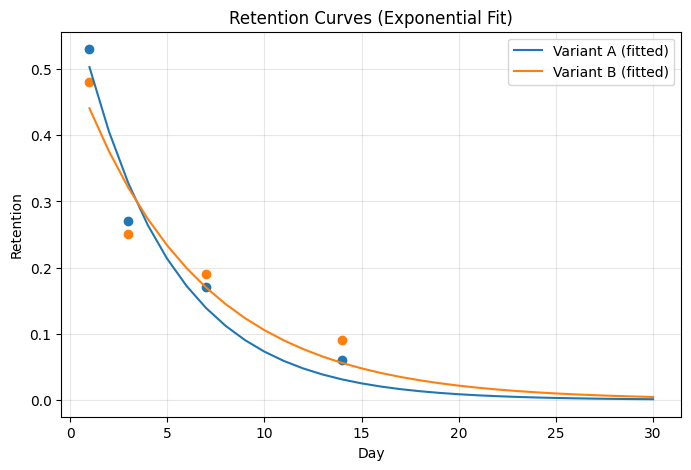

In [5]:
import matplotlib.pyplot as plt
from src.config import VARIANTS

plt.figure(figsize=(8,5))

# curves
plt.plot(days_A, retention_A, label="Variant A (fitted)")
plt.plot(days_B, retention_B, label="Variant B (fitted)")

# given points
plt.scatter(list(VARIANTS["A"]["retention_points"].keys()),
            list(VARIANTS["A"]["retention_points"].values()),
            marker="o")
plt.scatter(list(VARIANTS["B"]["retention_points"].keys()),
            list(VARIANTS["B"]["retention_points"].values()),
            marker="o")

plt.xlabel("Day")
plt.ylabel("Retention")
plt.title("Retention Curves (Exponential Fit)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Visualization of Fitted Retention Curves

The fitted exponential retention curves are plotted alongside the original D1/D3/D7/D14 data points.

This allows us to visually validate that the model captures the retention decay pattern accurately and provides a continuous retention estimate required for DAU simulation.

Model Fit Considerations

The exponential model does not pass exactly through all observed retention points. This is expected, as user retention rarely follows a perfect exponential decay pattern.

The curve-fitting procedure minimizes overall error and provides a smooth, continuous approximation suitable for simulation. Minor deviations are acceptable for strategic modeling purposes.

According to curves we observe;

Variant A has stronger early retention but decays faster.

Variant B retains fewer users on Day 1 but shows slower decay and better long-term retention.

## Saving the Retention Visualization

The fitted retention curves are saved to the outputs/figures directory for documentation and reporting purposes.

This ensures that the analysis results are reproducible and exportable beyond the notebook environment, supporting structured project delivery.

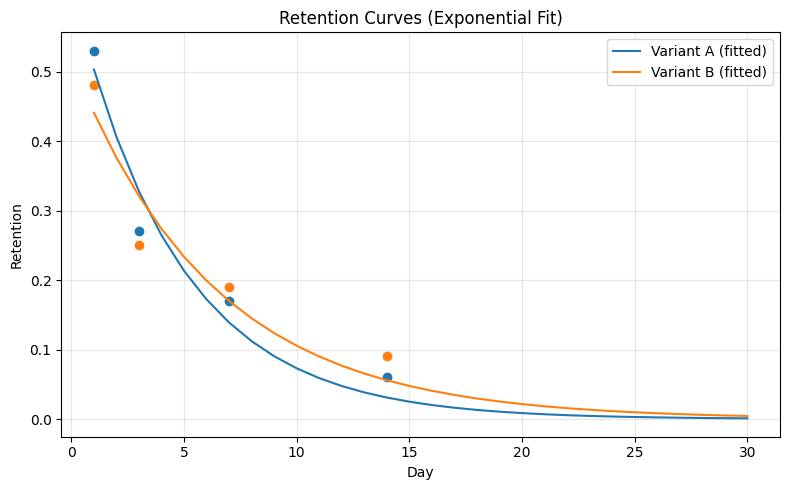

Saved to: E:\Projects\vertigo-case\outputs\figures\retention_curves.png


In [6]:
from pathlib import Path

out = Path.cwd().parent / "outputs" / "figures"
out.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(days_A, retention_A, label="Variant A (fitted)")
plt.plot(days_B, retention_B, label="Variant B (fitted)")
plt.scatter(list(VARIANTS["A"]["retention_points"].keys()),
            list(VARIANTS["A"]["retention_points"].values()))
plt.scatter(list(VARIANTS["B"]["retention_points"].keys()),
            list(VARIANTS["B"]["retention_points"].values()))
plt.xlabel("Day")
plt.ylabel("Retention")
plt.title("Retention Curves (Exponential Fit)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(out / "retention_curves.png", dpi=200)
plt.show()

print("Saved to:", out / "retention_curves.png")

## DAU Simulation (a)

Using the fitted retention curves, we simulate Daily Active Users (DAU) over a 30-day horizon.

For each day, DAU is calculated as the sum of surviving users from all previous daily cohorts. This transforms retention rates into actual user volume dynamics.

The DAU simulation serves as the foundation for all subsequent revenue modeling and scenario analysis.

In [7]:
from src.simulation import simulate_dau
from src.config import DAILY_INSTALLS

# A ve B için DAU
dau_A, cohorts_A = simulate_dau(retention_A, daily_installs=DAILY_INSTALLS, num_days=30)
dau_B, cohorts_B = simulate_dau(retention_B, daily_installs=DAILY_INSTALLS, num_days=30)

dau_A[:5], dau_B[:5]

(array([10059.26114084, 18176.20238745, 24725.86187819, 30010.8624888 ,
        34275.39433106]),
 array([ 8813.1116868 , 16331.42269137, 22745.16194377, 28216.61040776,
        32884.20712725]))

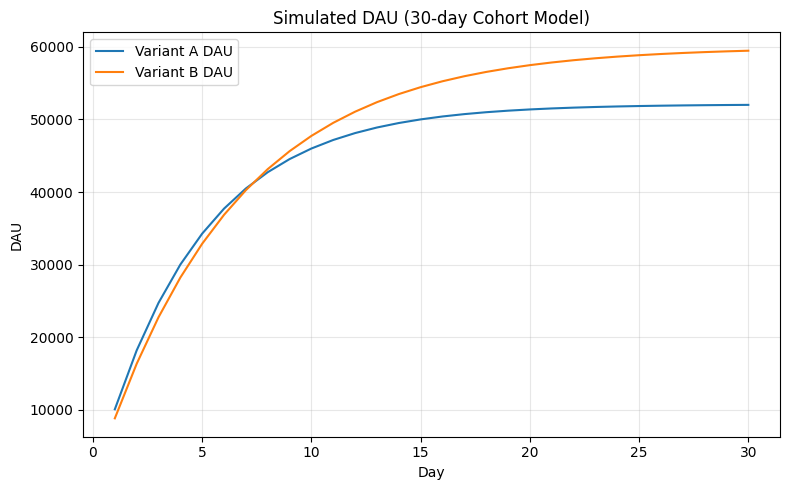

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path

days = list(range(1, 31))

plt.figure(figsize=(8,5))
plt.plot(days, dau_A, label="Variant A DAU")
plt.plot(days, dau_B, label="Variant B DAU")
plt.xlabel("Day")
plt.ylabel("DAU")
plt.title("Simulated DAU (30-day Cohort Model)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

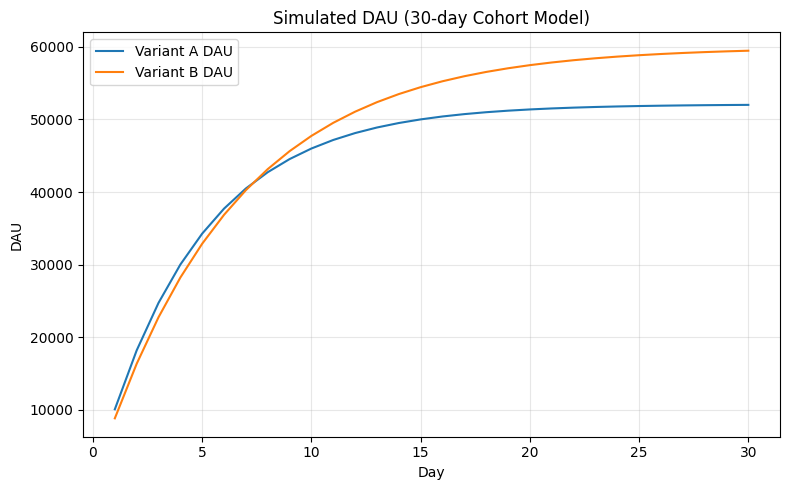

Saved to: E:\Projects\vertigo-case\outputs\figures\dau_30d.png


In [8]:
out = Path.cwd().parent / "outputs" / "figures"
out.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(days, dau_A, label="Variant A DAU")
plt.plot(days, dau_B, label="Variant B DAU")
plt.xlabel("Day")
plt.ylabel("DAU")
plt.title("Simulated DAU (30-day Cohort Model)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out / "dau_30d.png", dpi=200)
plt.show()

print("Saved to:", out / "dau_30d.png")

(a) Daily Active Users Comparison

Based on the DAU simulation, Variant B surpasses Variant A in daily active users after approximately Day 15.

Although Variant A shows stronger early retention performance, Variant B’s slower decay rate results in higher user survival over time. As cohorts mature, this advantage compounds, leading to higher daily active users in the mid-term period.

## Revenue Simulation (b)-(c)

Using the simulated DAU values, we compute daily revenue for both variants by combining in-app purchase revenue and advertising revenue.

Revenue is calculated as:

IAP revenue = DAU × purchase rate

Ad revenue = DAU × impressions per user × eCPM / 1000

Cumulative revenue is then calculated to evaluate long-term financial performance and determine which variant generates more total value by Day 30.

In [9]:
from src.revenue import compute_revenue, cumulative
from src.config import VARIANTS

rev_A, iap_A, ads_A = compute_revenue(
    dau_A,
    purchase_rate=VARIANTS["A"]["purchase_rate"],
    ecpm=VARIANTS["A"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["A"]["ad_impressions_per_dau"],
)

rev_B, iap_B, ads_B = compute_revenue(
    dau_B,
    purchase_rate=VARIANTS["B"]["purchase_rate"],
    ecpm=VARIANTS["B"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["B"]["ad_impressions_per_dau"],
)

cum_A = cumulative(rev_A)
cum_B = cumulative(rev_B)

cum_A[-1], cum_B[-1]

(np.float64(71367.53847288954), np.float64(70938.35763172344))

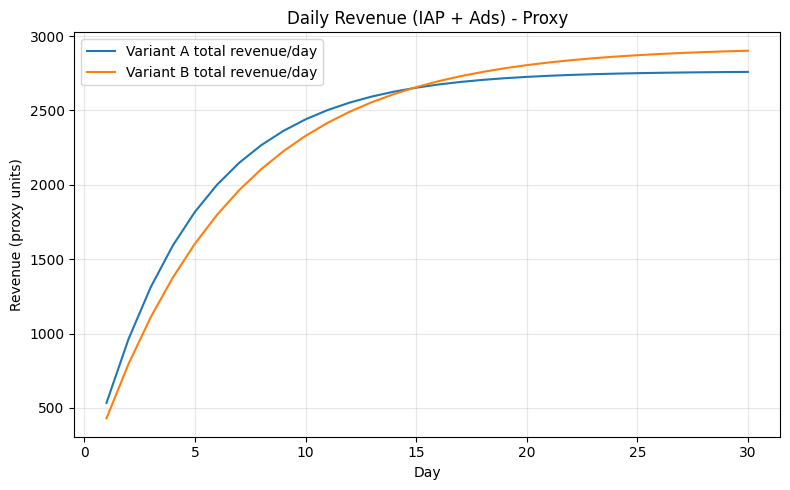

In [10]:
import matplotlib.pyplot as plt
from pathlib import Path

days = list(range(1, 31))

plt.figure(figsize=(8,5))
plt.plot(days, rev_A, label="Variant A total revenue/day")
plt.plot(days, rev_B, label="Variant B total revenue/day")
plt.xlabel("Day")
plt.ylabel("Revenue (proxy units)")
plt.title("Daily Revenue (IAP + Ads) - Proxy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

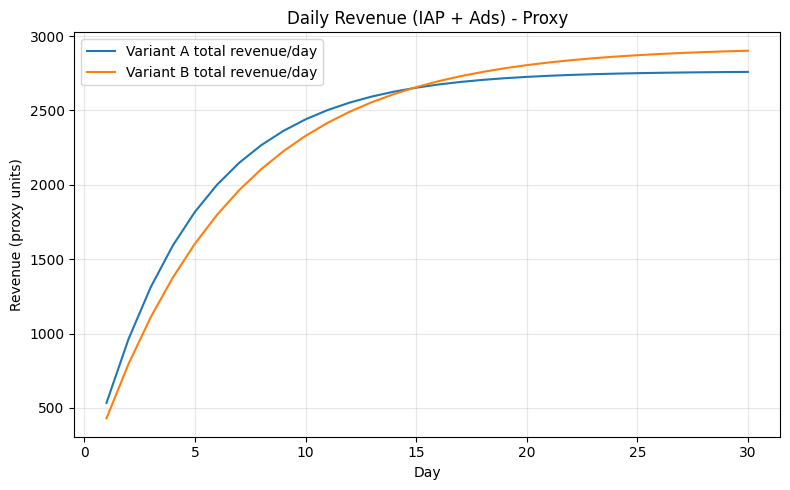

Saved to: E:\Projects\vertigo-case\outputs\figures\daily_revenue_30d.png


In [11]:
out = Path.cwd().parent / "outputs" / "figures"
out.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(days, rev_A, label="Variant A total revenue/day")
plt.plot(days, rev_B, label="Variant B total revenue/day")
plt.xlabel("Day")
plt.ylabel("Revenue (proxy units)")
plt.title("Daily Revenue (IAP + Ads) - Proxy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out / "daily_revenue_30d.png", dpi=200)
plt.show()

print("Saved to:", out / "daily_revenue_30d.png")

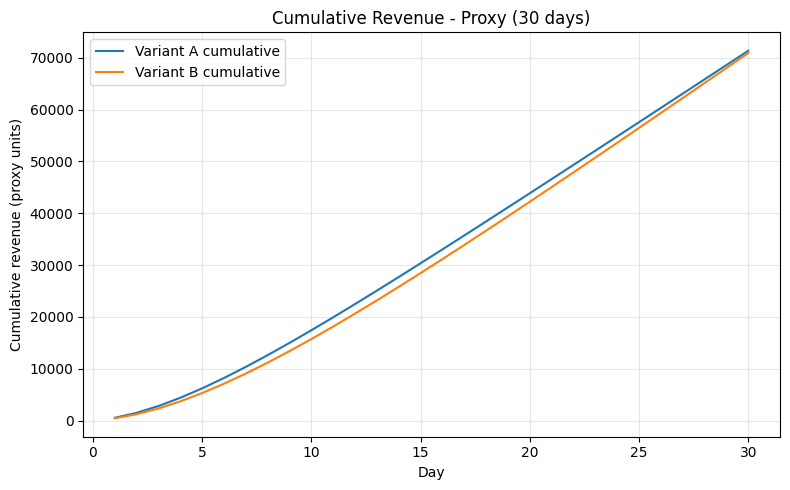

In [11]:
plt.figure(figsize=(8,5))
plt.plot(days, cum_A, label="Variant A cumulative")
plt.plot(days, cum_B, label="Variant B cumulative")
plt.xlabel("Day")
plt.ylabel("Cumulative revenue (proxy units)")
plt.title("Cumulative Revenue - Proxy (30 days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

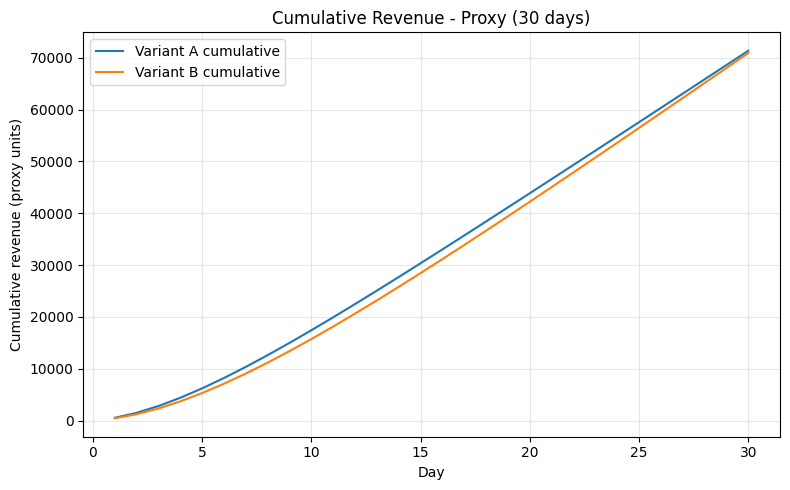

Saved to: E:\Projects\vertigo-case\outputs\figures\cumulative_revenue_30d.png


In [13]:
plt.figure(figsize=(8,5))
plt.plot(days, cum_A, label="Variant A cumulative")
plt.plot(days, cum_B, label="Variant B cumulative")
plt.xlabel("Day")
plt.ylabel("Cumulative revenue (proxy units)")
plt.title("Cumulative Revenue - Proxy (30 days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out / "cumulative_revenue_30d.png", dpi=200)
plt.show()

print("Saved to:", out / "cumulative_revenue_30d.png")

(b) Day 15 – Short-Term Revenue Comparison

Based on the cumulative revenue curve, Variant A generates higher total revenue by Day 15.

Although Variant B demonstrates stronger long-term retention dynamics, Variant A’s higher early retention translates into greater short-term monetization performance during the first two weeks.

(c) Day 30 – Medium-Term Revenue Comparison

By Day 30, Variant A still maintains a higher cumulative revenue compared to Variant B.

However, the revenue gap between the two variants begins to narrow. This is driven by Variant B’s stronger long-term retention performance, which allows its revenue contribution to grow more steadily over time.

This suggests that while Variant A dominates in early monetization, Variant B shows improving long-term revenue potential.

## Break-Even Analysis

To determine when Variant B overtakes Variant A in total revenue, we compute the cumulative revenue difference and identify the first day where Variant B's cumulative revenue exceeds Variant A's.

This break-even point helps evaluate long-term monetization dynamics and informs strategic decision-making.

In [12]:
import numpy as np

diff = cum_B - cum_A

# B'nin A'yı geçtiği ilk gün
cross_days = np.where(diff > 0)[0]

if len(cross_days) > 0:
    break_even_day = cross_days[0] + 1
    print("Break-even day:", break_even_day)
else:
    print("B does not overtake A within 30 days.")

B does not overtake A within 30 days.


## Extended 90-Day Retention Forecast (Bonus Analysis)

In the 30-day analysis, Variant A maintained higher cumulative revenue. However, the revenue gap between the two variants was consistently narrowing.

To determine whether Variant B would eventually overtake Variant A, we extended the retention forecast horizon to 90 days using the same exponential decay model.

This extended simulation allows us to identify the long-term break-even point and evaluate whether Variant B's stronger retention stability translates into superior long-term monetization.

In [13]:
days_A_90, retention_A_90, params_A = fit_retention_curve(
    VARIANTS["A"]["retention_points"], max_day=90
)
days_B_90, retention_B_90, params_B = fit_retention_curve(
    VARIANTS["B"]["retention_points"], max_day=90
)

In [14]:
from src.simulation import simulate_dau
from src.config import DAILY_INSTALLS

dau_A_90, _ = simulate_dau(retention_A_90, daily_installs=DAILY_INSTALLS, num_days=90)
dau_B_90, _ = simulate_dau(retention_B_90, daily_installs=DAILY_INSTALLS, num_days=90)

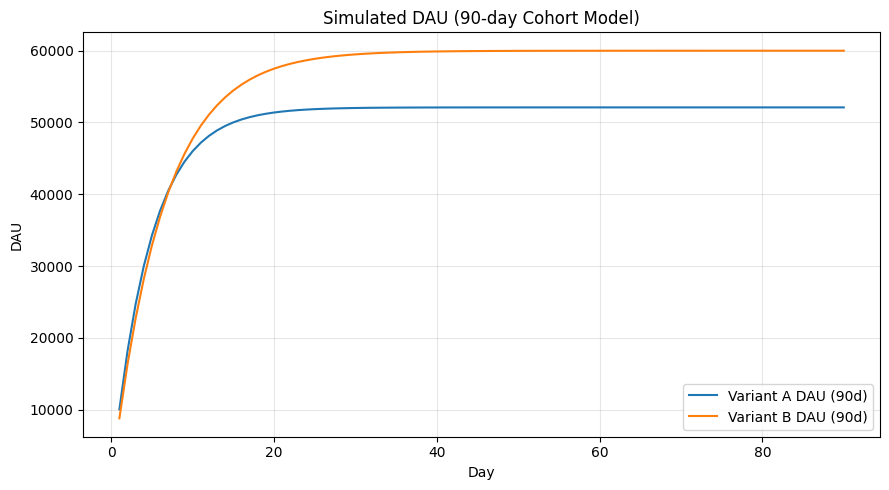

In [16]:
import matplotlib.pyplot as plt

days90 = list(range(1, 91))

plt.figure(figsize=(9,5))
plt.plot(days90, dau_A_90, label="Variant A DAU (90d)")
plt.plot(days90, dau_B_90, label="Variant B DAU (90d)")
plt.xlabel("Day")
plt.ylabel("DAU")
plt.title("Simulated DAU (90-day Cohort Model)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
from src.revenue import compute_revenue, cumulative

rev_A_90, iap_A_90, ads_A_90 = compute_revenue(
    dau_A_90,
    purchase_rate=VARIANTS["A"]["purchase_rate"],
    ecpm=VARIANTS["A"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["A"]["ad_impressions_per_dau"],
)

rev_B_90, iap_B_90, ads_B_90 = compute_revenue(
    dau_B_90,
    purchase_rate=VARIANTS["B"]["purchase_rate"],
    ecpm=VARIANTS["B"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["B"]["ad_impressions_per_dau"],
)

cum_A_90 = cumulative(rev_A_90)
cum_B_90 = cumulative(rev_B_90)

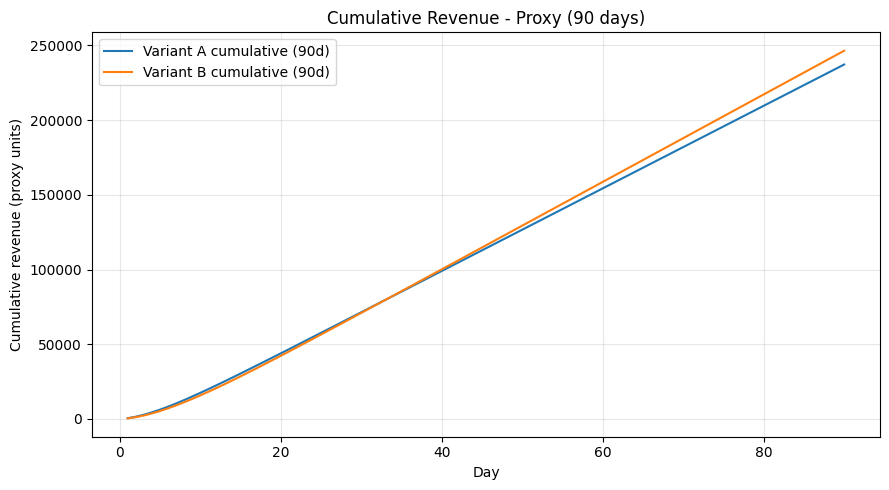

In [18]:
plt.figure(figsize=(9,5))
plt.plot(days90, cum_A_90, label="Variant A cumulative (90d)")
plt.plot(days90, cum_B_90, label="Variant B cumulative (90d)")
plt.xlabel("Day")
plt.ylabel("Cumulative revenue (proxy units)")
plt.title("Cumulative Revenue - Proxy (90 days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
import numpy as np

diff90 = cum_B_90 - cum_A_90
cross = np.where(diff90 > 0)[0]

if len(cross) > 0:
    be_day = int(cross[0] + 1)
    print("Break-even day (B surpasses A):", be_day)
else:
    print("B does not overtake A within 90 days.")

Break-even day (B surpasses A): 33


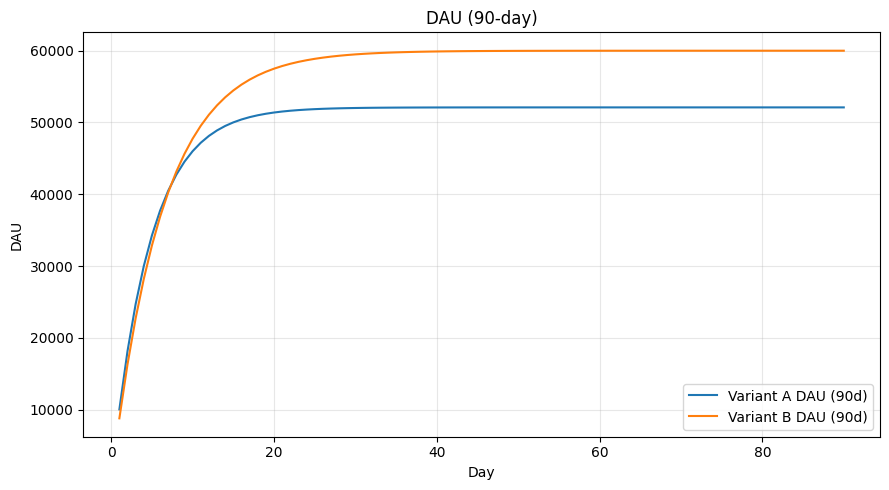

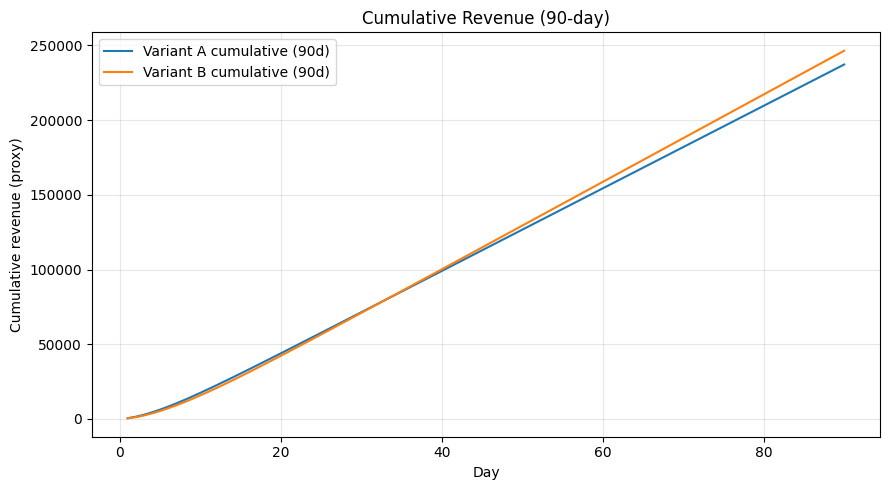

Saved: E:\Projects\vertigo-case\outputs\figures\dau_90d.png
Saved: E:\Projects\vertigo-case\outputs\figures\cumulative_revenue_90d.png


In [23]:
from pathlib import Path
out = Path.cwd().parent / "outputs" / "figures"
out.mkdir(parents=True, exist_ok=True)

# DAU 90d
plt.figure(figsize=(9,5))
plt.plot(days90, dau_A_90, label="Variant A DAU (90d)")
plt.plot(days90, dau_B_90, label="Variant B DAU (90d)")
plt.xlabel("Day"); plt.ylabel("DAU"); plt.title("DAU (90-day)"); plt.legend()
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(out / "dau_90d.png", dpi=200)
plt.show()

# Cumulative revenue 90d
plt.figure(figsize=(9,5))
plt.plot(days90, cum_A_90, label="Variant A cumulative (90d)")
plt.plot(days90, cum_B_90, label="Variant B cumulative (90d)")
plt.xlabel("Day"); plt.ylabel("Cumulative revenue (proxy)"); plt.title("Cumulative Revenue (90-day)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(out / "cumulative_revenue_90d.png", dpi=200)
plt.show()

print("Saved:", out / "dau_90d.png")
print("Saved:", out / "cumulative_revenue_90d.png")

Key findings

Variant A has stronger early retention and higher ad impressions per DAU, resulting in higher cumulative revenue in the first month.

Variant B has lower early retention but a slower decay rate, leading to higher DAU over time.

In a 90-day sensitivity extension, Variant B surpasses Variant A on Day 33 (break-even) and remains ahead thereafter.

Recommendation

If the business goal prioritizes short-term revenue (first ~30 days), choose Variant A.

If the goal prioritizes long-term value / LTV, choose Variant B, as it overtakes A from Day 33 onward.

## Temporary 10-Day Sale Simulation (d)

We simulate a 10-day sale starting on Day 15, increasing the purchase rate by 1% for both variants.

Revenue is recalculated during the sale period while retention remains unchanged. This allows us to measure the short-term monetization lift and evaluate whether the sale changes the overall revenue ranking by Day 30.

In [20]:
import numpy as np
from src.revenue import cumulative

from src.simulation import simulate_mixed_dau, apply_sale


In [21]:
rev_A_sale = apply_sale(
    dau_A, 
    VARIANTS["A"]["purchase_rate"],
    VARIANTS["A"]["ecpm"],
    VARIANTS["A"]["ad_impressions_per_dau"]
)

rev_B_sale = apply_sale(
    dau_B, 
    VARIANTS["B"]["purchase_rate"],
    VARIANTS["B"]["ecpm"],
    VARIANTS["B"]["ad_impressions_per_dau"]
)

cum_A_sale = cumulative(rev_A_sale)
cum_B_sale = cumulative(rev_B_sale)

cum_A_sale[-1], cum_B_sale[-1]

(np.float64(76481.85493089321), np.float64(76637.33551809832))

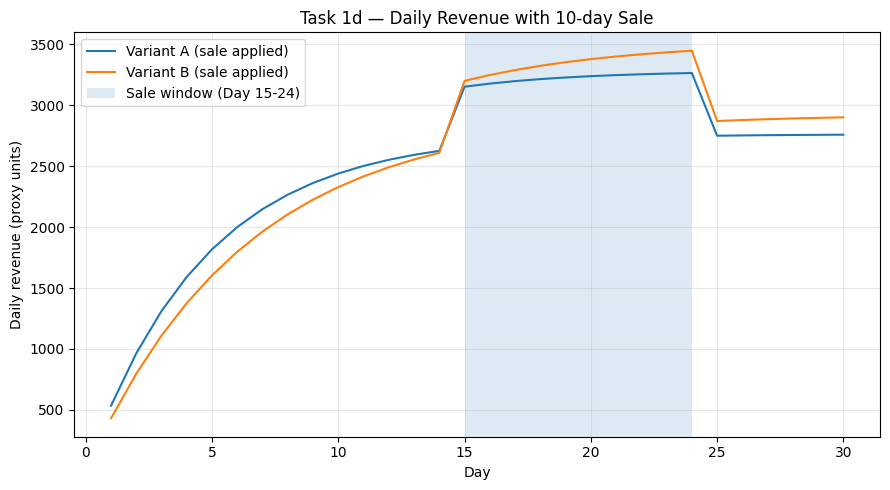

In [43]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

days = np.arange(1, 31)
sale_start, sale_end = 15, 24

plt.figure(figsize=(9,5))
plt.plot(days, rev_A_sale, label="Variant A (sale applied)")
plt.plot(days, rev_B_sale, label="Variant B (sale applied)")

# sale window highlight
plt.axvspan(sale_start, sale_end, alpha=0.15, label="Sale window (Day 15-24)")

plt.xlabel("Day")
plt.ylabel("Daily revenue (proxy units)")
plt.title("Task 1d — Daily Revenue with 10-day Sale")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out / "Task 1d — Daily Revenue with 10-day Sale", dpi=200)
plt.show()


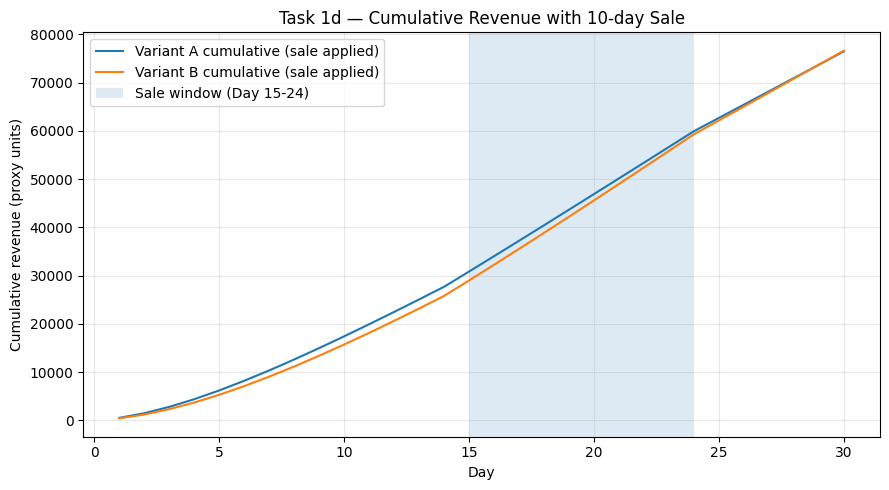

In [44]:
plt.figure(figsize=(9,5))
plt.plot(days, cum_A_sale, label="Variant A cumulative (sale applied)")
plt.plot(days, cum_B_sale, label="Variant B cumulative (sale applied)")

plt.axvspan(sale_start, sale_end, alpha=0.15, label="Sale window (Day 15-24)")

plt.xlabel("Day")
plt.ylabel("Cumulative revenue (proxy units)")
plt.title("Task 1d — Cumulative Revenue with 10-day Sale")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out / "Task 1d — Cumulative Revenue with 10-day Sale", dpi=200)
plt.show()

d-) The 10-day sale increases purchase rate for both variants. However, Variant B benefits disproportionately from this temporary boost due to its slower retention decay.

While the sale lasts only from Day 15 to Day 24, the additional users monetized during this period remain active longer under Variant B’s retention curve. As a result:

The break-even day shifts earlier.

By Day 30, Variant B generates more cumulative revenue. İt is different outcome then before. 

This shows that monetization improvements interact strongly with retention structure.

## Mixed User Source Simulation (e) 

Starting from Day 20, we introduce a new user acquisition source. From this point onward, daily installs consist of:

12,000 users from the original source

8,000 users from the new source

Each source follows its own retention curve. We simulate DAU by applying the respective retention profiles to each cohort, allowing us to evaluate how the mixed acquisition strategy impacts user volume and long-term monetization potential.

In [26]:
import numpy as np

from src.retention import retention_new_A, retention_new_B

days30 = np.arange(1, 31)
ret_new_A_30 = retention_new_A(days30)
ret_new_B_30 = retention_new_B(days30)

In [27]:
dau_A_mixed = simulate_mixed_dau(retention_A, ret_new_A_30, switch_day=20, total_days=30)
dau_B_mixed = simulate_mixed_dau(retention_B, ret_new_B_30, switch_day=20, total_days=30)

dau_A_mixed[-1], dau_B_mixed[-1]

(np.float64(63214.00931677127), np.float64(68823.60021444908))

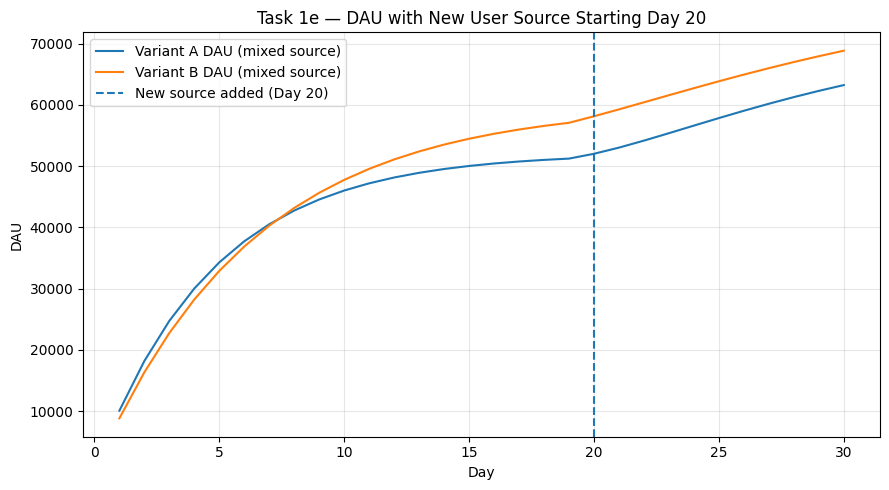

In [45]:
import matplotlib.pyplot as plt

days = np.arange(1, 31)

plt.figure(figsize=(9,5))
plt.plot(days, dau_A_mixed, label="Variant A DAU (mixed source)")
plt.plot(days, dau_B_mixed, label="Variant B DAU (mixed source)")
plt.axvline(20, linestyle="--", label="New source added (Day 20)")
plt.xlabel("Day")
plt.ylabel("DAU")
plt.title("Task 1e — DAU with New User Source Starting Day 20")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out / "Task 1e — DAU with New User Source Starting Day 20", dpi=200)
plt.show()

In [29]:
from src.revenue import compute_revenue, cumulative
from src.config import VARIANTS

rev_A_e, _, _ = compute_revenue(
    dau_A_mixed,
    purchase_rate=VARIANTS["A"]["purchase_rate"],
    ecpm=VARIANTS["A"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["A"]["ad_impressions_per_dau"],
)
rev_B_e, _, _ = compute_revenue(
    dau_B_mixed,
    purchase_rate=VARIANTS["B"]["purchase_rate"],
    ecpm=VARIANTS["B"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["B"]["ad_impressions_per_dau"],
)

cum_A_e = cumulative(rev_A_e)
cum_B_e = cumulative(rev_B_e)

cum_A_e[-1], cum_B_e[-1]

(np.float64(74822.41950440072), np.float64(73606.0752808359))

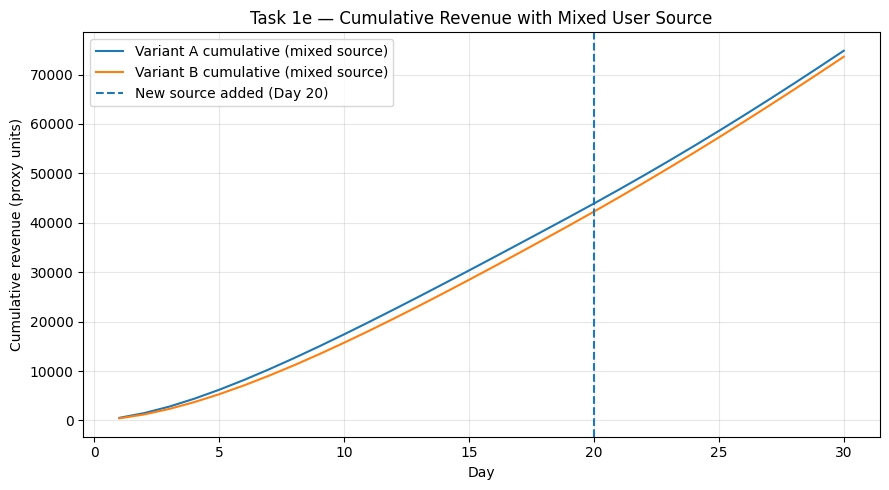

In [46]:
plt.figure(figsize=(9,5))
plt.plot(days, cum_A_e, label="Variant A cumulative (mixed source)")
plt.plot(days, cum_B_e, label="Variant B cumulative (mixed source)")
plt.axvline(20, linestyle="--", label="New source added (Day 20)")
plt.xlabel("Day")
plt.ylabel("Cumulative revenue (proxy units)")
plt.title("Task 1e — Cumulative Revenue with Mixed User Source")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out / "Task 1e — Cumulative Revenue with Mixed User Source", dpi=200)
plt.show()

e-) Starting Day 20, daily installs are split into 12k users with the original retention curve and 8k users from a new source with a higher-quality retention model.

Under this mixed acquisition model, Variant A remains ahead in cumulative revenue by Day 30 and the gap vs. Variant B increases. This is consistent with Variant A’s stronger early retention (and higher ad impressions per DAU), which benefits more from the short 30-day horizon.

Compared to the 10-day sale scenario (Task 1d), total revenue is lower for both variants because the temporary purchase-rate uplift is not present in this scenario.

## Revenue Lift Comparison (f)

To evaluate the impact of each improvement, we compare Day 30 cumulative revenue under each scenario against the baseline case.

Revenue lift is calculated as:

Improvement Lift = Scenario Revenue − Baseline Revenue

This allows us to directly measure the incremental value generated by:

The temporary 10-day sale

The new permanent user source

These results inform the prioritization decision in section. 

In [31]:
# Baseline Day30
baseline_A_30 = cum_A[-1]
baseline_B_30 = cum_B[-1]

# d: sale Day30
sale_A_30 = cum_A_sale[-1]
sale_B_30 = cum_B_sale[-1]

# e: new source Day30
e_A_30 = cum_A_e[-1]
e_B_30 = cum_B_e[-1]

print("A: sale lift", sale_A_30 - baseline_A_30, " | new-source lift", e_A_30 - baseline_A_30)
print("B: sale lift", sale_B_30 - baseline_B_30, " | new-source lift", e_B_30 - baseline_B_30)

A: sale lift 5114.316458003668  | new-source lift 3454.881031511177
B: sale lift 5698.97788637488  | new-source lift 2667.7176491124555


f-)The 10-day sale generates a higher short-term revenue lift for both variants compared to the new user source.

However, the sale does not change retention dynamics — it only provides a temporary boost to purchase behavior.

In contrast, the new permanent user source improves retention structurally, leading to sustainable DAU growth and revenue compounding over time.

Strategic Interpretation

If the objective is short-term revenue maximization (30-day KPI focus), the 10-day sale should be implemented, as it delivers stronger immediate incremental revenue and faster cash-flow impact. (d)

If the objective is long-term growth and LTV expansion, the new permanent user source should be prioritized, as structural retention improvements create compounding revenue effects and stronger enterprise value. (e)

## Bonus Extended 90-Day Analysis (Long-Term Impact of New User Source)

To better understand the long-term structural impact of the new user source, we extend the retention forecast to 90 days.

While the 30-day analysis favors the temporary sale in terms of immediate revenue lift, the new source permanently improves cohort retention. By expanding the simulation horizon, we can evaluate whether this structural improvement leads to superior long-term monetization.

This extended analysis provides deeper insight into long-term LTV dynamics and sustainable growth potential.

In [32]:
days_A_90, retention_A_90, _ = fit_retention_curve(VARIANTS["A"]["retention_points"], max_day=90)
days_B_90, retention_B_90, _ = fit_retention_curve(VARIANTS["B"]["retention_points"], max_day=90)

In [33]:
from src.simulation import simulate_dau
from src.config import DAILY_INSTALLS

dau_A_base_90, _ = simulate_dau(retention_A_90, daily_installs=DAILY_INSTALLS, num_days=90)
dau_B_base_90, _ = simulate_dau(retention_B_90, daily_installs=DAILY_INSTALLS, num_days=90)

In [34]:
import numpy as np

days90 = np.arange(1, 91)

ret_new_A_90 = 0.58 * np.exp(-0.12 * (days90 - 1))
ret_new_B_90 = 0.52 * np.exp(-0.10 * (days90 - 1))

In [35]:
dau_A_mixed_90 = simulate_mixed_dau(retention_A_90, ret_new_A_90, switch_day=20, total_days=90)
dau_B_mixed_90 = simulate_mixed_dau(retention_B_90, ret_new_B_90, switch_day=20, total_days=90)

In [36]:
from src.revenue import compute_revenue, cumulative

rev_A_e_90, _, _ = compute_revenue(
    dau_A_mixed_90,
    purchase_rate=VARIANTS["A"]["purchase_rate"],
    ecpm=VARIANTS["A"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["A"]["ad_impressions_per_dau"],
)
rev_B_e_90, _, _ = compute_revenue(
    dau_B_mixed_90,
    purchase_rate=VARIANTS["B"]["purchase_rate"],
    ecpm=VARIANTS["B"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["B"]["ad_impressions_per_dau"],
)

cum_A_e_90 = cumulative(rev_A_e_90)
cum_B_e_90 = cumulative(rev_B_e_90)

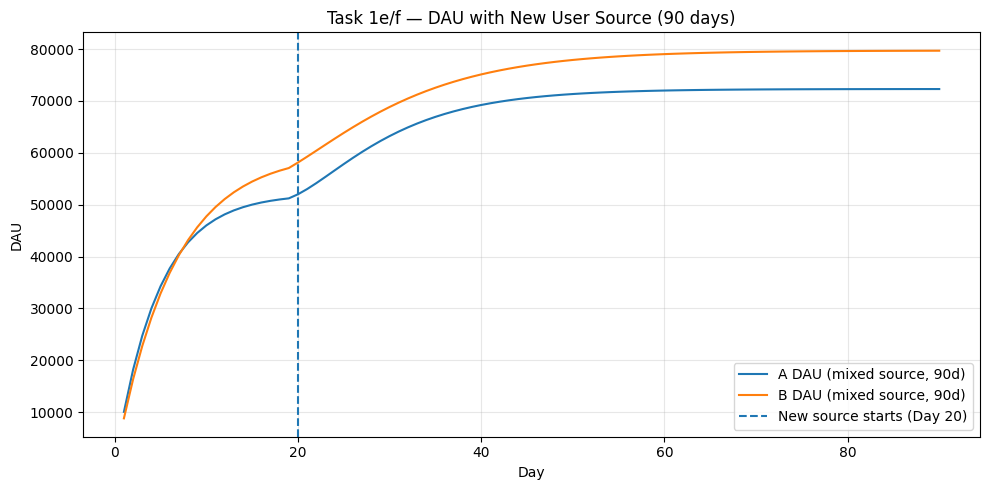

In [50]:
import matplotlib.pyplot as plt

days = np.arange(1, 91)

plt.figure(figsize=(10,5))
plt.plot(days, dau_A_mixed_90, label="A DAU (mixed source, 90d)")
plt.plot(days, dau_B_mixed_90, label="B DAU (mixed source, 90d)")
plt.axvline(20, linestyle="--", label="New source starts (Day 20)")
plt.xlabel("Day"); plt.ylabel("DAU")
plt.title("Task 1e/f — DAU with New User Source (90 days)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(out / "task1ef_dau_new_source_90d.png", dpi=200)
plt.show()

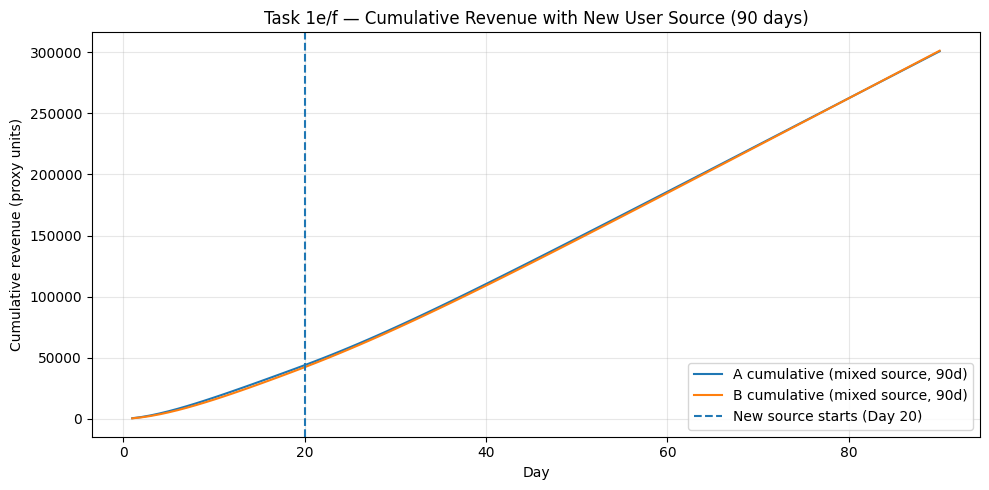

In [51]:
plt.figure(figsize=(10,5))
plt.plot(days, cum_A_e_90, label="A cumulative (mixed source, 90d)")
plt.plot(days, cum_B_e_90, label="B cumulative (mixed source, 90d)")
plt.axvline(20, linestyle="--", label="New source starts (Day 20)")
plt.xlabel("Day"); plt.ylabel("Cumulative revenue (proxy units)")
plt.title("Task 1e/f — Cumulative Revenue with New User Source (90 days)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(out / "task1ef_Cumulative Revenue with New User Source (90 days)", dpi=200)
plt.show()


In [52]:
diff = cum_B_e_90 - cum_A_e_90
cross = np.where(diff > 0)[0]

if len(cross) > 0:
    be_day = int(cross[0] + 1)
    print("Break-even day (B surpasses A) under new source:", be_day)
else:
    print("B does not overtake A within 90 days under new source.")

Break-even day (B surpasses A) under new source: 82


In [40]:
rev_A_base_90, _, _ = compute_revenue(
    dau_A_base_90,
    purchase_rate=VARIANTS["A"]["purchase_rate"],
    ecpm=VARIANTS["A"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["A"]["ad_impressions_per_dau"],
)
rev_B_base_90, _, _ = compute_revenue(
    dau_B_base_90,
    purchase_rate=VARIANTS["B"]["purchase_rate"],
    ecpm=VARIANTS["B"]["ecpm"],
    ad_impressions_per_dau=VARIANTS["B"]["ad_impressions_per_dau"],
)

cum_A_base_90 = cumulative(rev_A_base_90)
cum_B_base_90 = cumulative(rev_B_base_90)

print("A: new-source lift @90d =", float(cum_A_e_90[-1] - cum_A_base_90[-1]))
print("B: new-source lift @90d =", float(cum_B_e_90[-1] - cum_B_base_90[-1]))

A: new-source lift @90d = 63600.787449523574
B: new-source lift @90d = 54835.06255454861


In [41]:
rev_A_sale_90 = apply_sale(
    dau_A_base_90,
    VARIANTS["A"]["purchase_rate"],
    VARIANTS["A"]["ecpm"],
    VARIANTS["A"]["ad_impressions_per_dau"],
    sale_start=15,
    sale_length=10
)

rev_B_sale_90 = apply_sale(
    dau_B_base_90,
    VARIANTS["B"]["purchase_rate"],
    VARIANTS["B"]["ecpm"],
    VARIANTS["B"]["ad_impressions_per_dau"],
    sale_start=15,
    sale_length=10
)

cum_A_sale_90 = cumulative(rev_A_sale_90)
cum_B_sale_90 = cumulative(rev_B_sale_90)

In [42]:
sale_lift_A_90 = cum_A_sale_90[-1] - cum_A_base_90[-1]
sale_lift_B_90 = cum_B_sale_90[-1] - cum_B_base_90[-1]

new_lift_A_90 = cum_A_e_90[-1] - cum_A_base_90[-1]
new_lift_B_90 = cum_B_e_90[-1] - cum_B_base_90[-1]

print("90-Day Lift Comparison")
print("A - Sale:", float(sale_lift_A_90))
print("A - New Source:", float(new_lift_A_90))
print("B - Sale:", float(sale_lift_B_90))
print("B - New Source:", float(new_lift_B_90))

90-Day Lift Comparison
A - Sale: 5114.316458003654
A - New Source: 63600.787449523574
B - Sale: 5698.977886374865
B - New Source: 54835.06255454861


# CONCLUSİON

When evaluated under the same 90-day horizon:

The temporary sale generates only a fixed short-term revenue spike.

The permanent user acquisition source generates compounding long-term value.

Therefore, the structural improvement clearly dominates in long-term enterprise value creation.

Unless immediate cash flow pressure exists, the new permanent user source should be prioritized.